# TP3: Predictive functions

## Winter 2023 - BIN710 Data Mining (UdeS)

Third assignement as part of the Data Mining class at UdeS.

Student name : Simon Lalonde

### Directory structure

├── TP3_data.csv    ---> Data

├── TP3_soln.ipynb   ---> Jupyter Notebook

└── TP3.pdf    ---> Tasks to complete

### Data
1 file, blobs with noise.
- 10K objects
- 4 attributes
- 20 classes (0 to 19)

### Goal
Implement, use and compare the results from hyperparameter optimization techniques (such as GridSearch) for KNN classifier

---

In [100]:
from pathlib import Path
import random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import choice

from scipy.stats import shapiro
from scipy.stats import iqr
from scipy.stats import norm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


### Hyperparameters to tune

In the context of KNN Classifier model, we have to tune 2 hyperparameters:

- n_neighors (range(1, 20, step=1))
- p (range(1, 10, step=1))

**So we have 20x10 = 200 unique combinatations of hyperparams to test/tune using different methods**

## 0. Data exploration

### Read and explore briefly the data

In [3]:
# dir/file read setup
root_dir = Path.cwd()
datafile = "TP3_data.csv"
df = pd.read_csv(root_dir / datafile)
df.head()

Unnamed: 0  Attribut1  Attribut2  Attribut3  Attribut4  Classe
0           0  -7.662408  -5.851448   5.958728   7.846234     5.0
1           1  -5.287012 -10.373240   9.883442   8.947388     5.0
2           2  -8.048882  -5.600485   2.384850  -9.083051     8.0
3           3 -15.243415  -5.925116  -0.348595  -6.381597     8.0
4           4   3.693635  -7.545713  -0.465179  -1.017517    16.0

In [4]:
# Removing redundant index
df = df.drop(columns=df.columns[0])

In [5]:
df.dtypes

Attribut1    float64
Attribut2    float64
Attribut3    float64
Attribut4    float64
Classe       float64
dtype: object

In [6]:
# Changing classes to int
df["Classe"] = df["Classe"].astype(int)
df.dtypes


Attribut1    float64
Attribut2    float64
Attribut3    float64
Attribut4    float64
Classe         int64
dtype: object

In [7]:
df.columns[-1]

'Classe'

In [8]:
# Saving features, class names and splitting in X/y arrays
features = df.columns[:-1].to_list()
class_name = df.columns[-1]
X = df[features]
y = df[class_name]

In [9]:
print(f"features : {features}")
print(f"class name : {class_name}")

features : ['Attribut1', 'Attribut2', 'Attribut3', 'Attribut4']
class name : Classe


In [10]:
X.head()

Attribut1  Attribut2  Attribut3  Attribut4
0  -7.662408  -5.851448   5.958728   7.846234
1  -5.287012 -10.373240   9.883442   8.947388
2  -8.048882  -5.600485   2.384850  -9.083051
3 -15.243415  -5.925116  -0.348595  -6.381597
4   3.693635  -7.545713  -0.465179  -1.017517

In [11]:
y.head()

0     5
1     5
2     8
3     8
4    16
Name: Classe, dtype: int64

#### Features distribution, dispersion and correlations

In [12]:
# Check distributions
def get_distributions(data, features, plt_rows, plt_cols, feat_color=True, hue=None, bins='auto', binwidth=None, kde=True):
    # Square subplots
    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(8,10))
    axes = axes.ravel()

    for i, feat in enumerate(features):
        if feat_color:
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=sns.color_palette()[i])
        else :
            feat_color = None
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=feat_color)
        plot.set(title=f"Distribution for : {feat}")
        plot.set(xlabel="")

    fig.tight_layout()

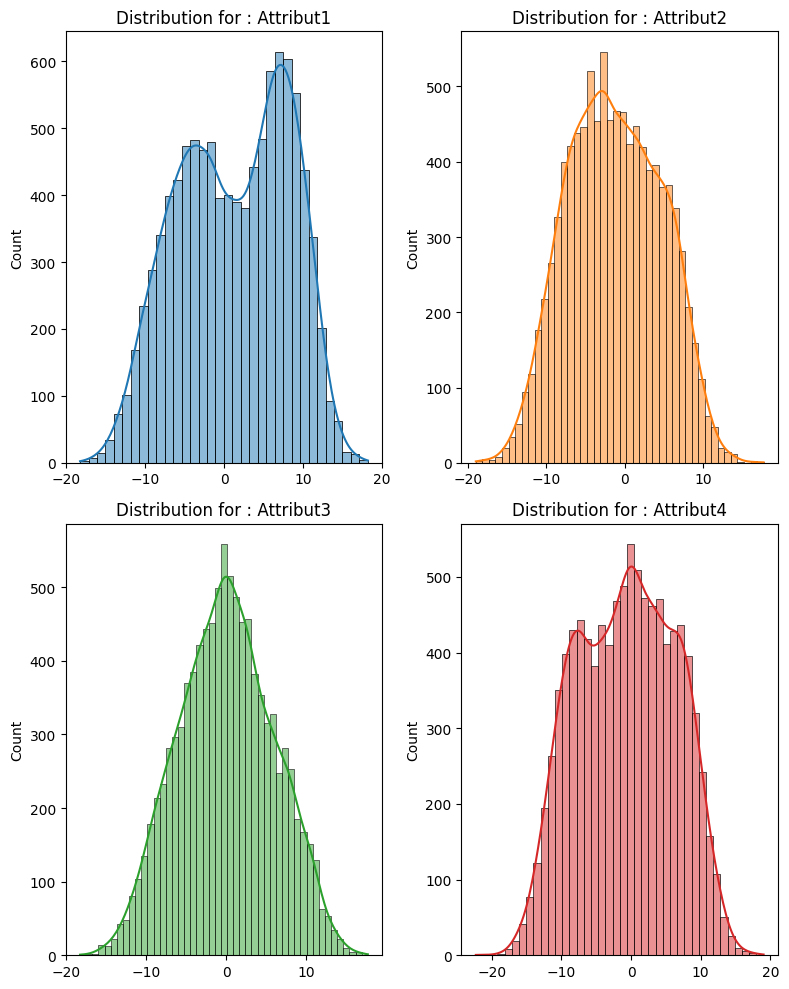

In [13]:
# Auto bins
get_distributions(X, features, 2, 2)

Visualize with wider bins

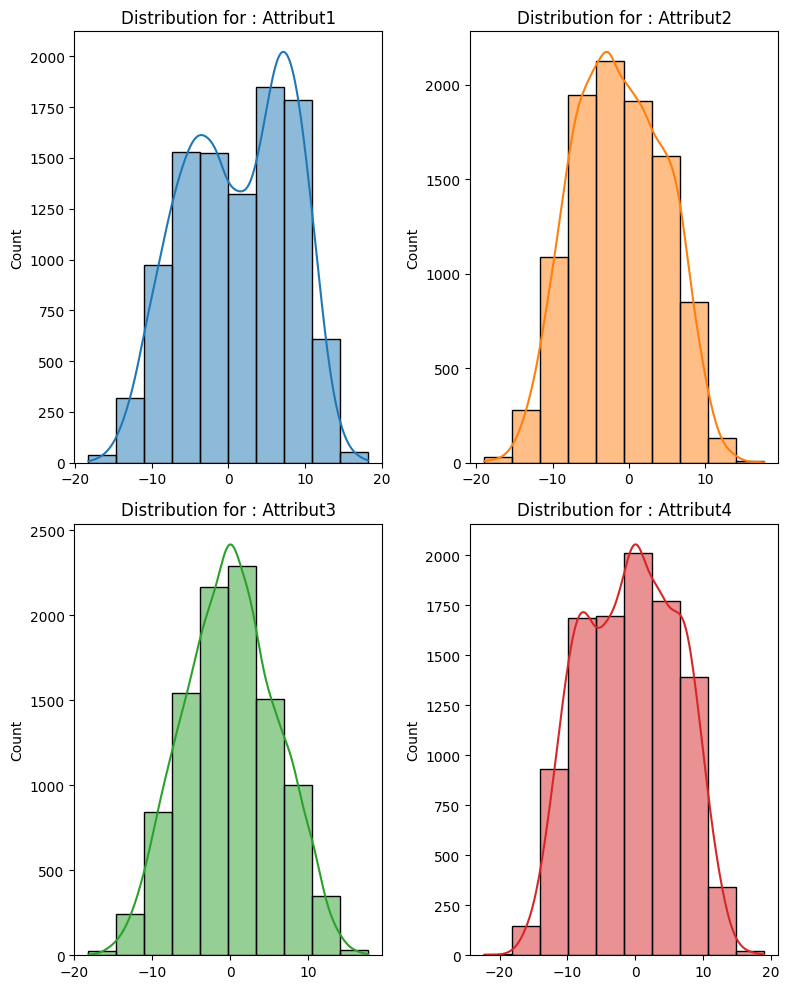

In [14]:
get_distributions(X, features, 2, 2, bins=int(len(X)/1000))


**Att2, Att3 seem normally distributed, while Att4 might be as well but kurtosis is different. Att1 has bimodal distribution**

In [15]:
def check_normality(df, features):
    for feat in features:
        norm = shapiro(df[feat])
        if norm.pvalue < 0.05:
            print(f"{feat} is not normally distributed since pval={norm.pvalue} < 0.05")
        else:
            print(f"{feat} follows a normal distribution (null hypothesis)")

In [16]:
check_normality(df, features)

Attribut1 is not normally distributed since pval=1.0769216919075154e-39 < 0.05
Attribut2 is not normally distributed since pval=2.298475423334648e-24 < 0.05
Attribut3 is not normally distributed since pval=2.6933894364485934e-15 < 0.05
Attribut4 is not normally distributed since pval=3.646550984195728e-32 < 0.05


/home/local/USHERBROOKE/lals2906/programming/py_env/py3_ds/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**We cannot check Normality with a standard Shap-Wilk test since we have a large amount of objects and thus hypothesis testing will always yields a rejection of the null hypothesis since not a lot of points are needed to deviate**

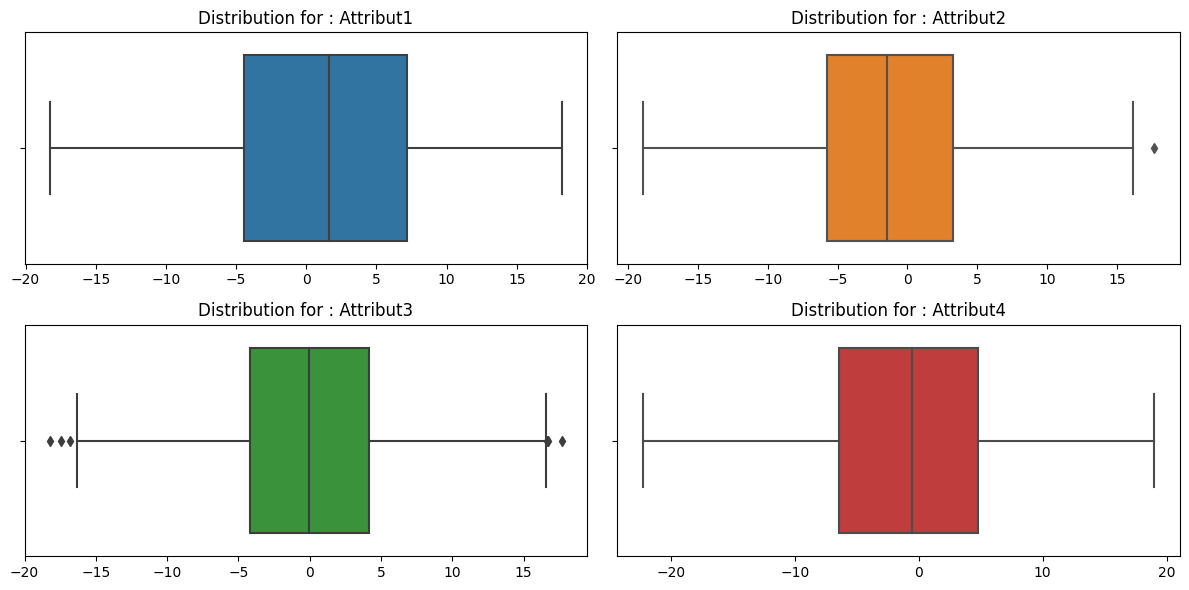

In [17]:
def get_boxplots(df, features, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(12,6))
    axes = axes.ravel()

    for i, feat in enumerate(features):
        plot = sns.boxplot(data=df, x=feat, ax=axes[i], color=sns.color_palette()[i])
        plot.set(title=f"Distribution for : {feat}")
        plot.set(xlabel="")

    fig.tight_layout()
get_boxplots(df, features, 2, 2)

Let's check those outliers for Att2 and Att3

In [18]:
def get_outliers(df, feat):
    iqr_feat = iqr(df[feat])
    
    # Get quartiles and outlier limits
    q1, q2, q3, = df.quantile(np.linspace(0.25, 0.75, num=3))[feat].astype(int)
    lower_lim = q1 - 1.5*iqr_feat
    upper_lim = q3 + 1.5*iqr_feat

    # print outliers
    if len(df[df[feat] > upper_lim][feat].values) > 0 or len(df[df[feat] < lower_lim][feat].values) > 0:
        upper_lim_outliers = df[df[feat] > upper_lim][feat]
        lower_lim_outliers = df[df[feat] < lower_lim][feat]
        print(f"{len(lower_lim_outliers)+len(upper_lim_outliers)} outliers for {feat}:\n")
        print(upper_lim_outliers)
        print(lower_lim_outliers)
        print("\n")
for i in range(len(features)):
    get_outliers(df, features[i])

3 outliers for Attribut2:

6000    17.688653
Name: Attribut2, dtype: float64
5488   -18.962684
6463   -18.815461
Name: Attribut2, dtype: float64


7 outliers for Attribut3:

551     16.660461
3392    16.697278
5363    17.670892
6725    16.534034
Name: Attribut3, dtype: float64
4620   -18.208884
5501   -17.444804
5887   -16.820523
Name: Attribut3, dtype: float64




**All features are uncorrelated with each other**

In [19]:
X.corr()[abs(X.corr()) > 0.5]

Attribut1  Attribut2  Attribut3  Attribut4
Attribut1        1.0        NaN        NaN        NaN
Attribut2        NaN        1.0        NaN        NaN
Attribut3        NaN        NaN        1.0        NaN
Attribut4        NaN        NaN        NaN        1.0

#### Distributions for classes or class balancing?

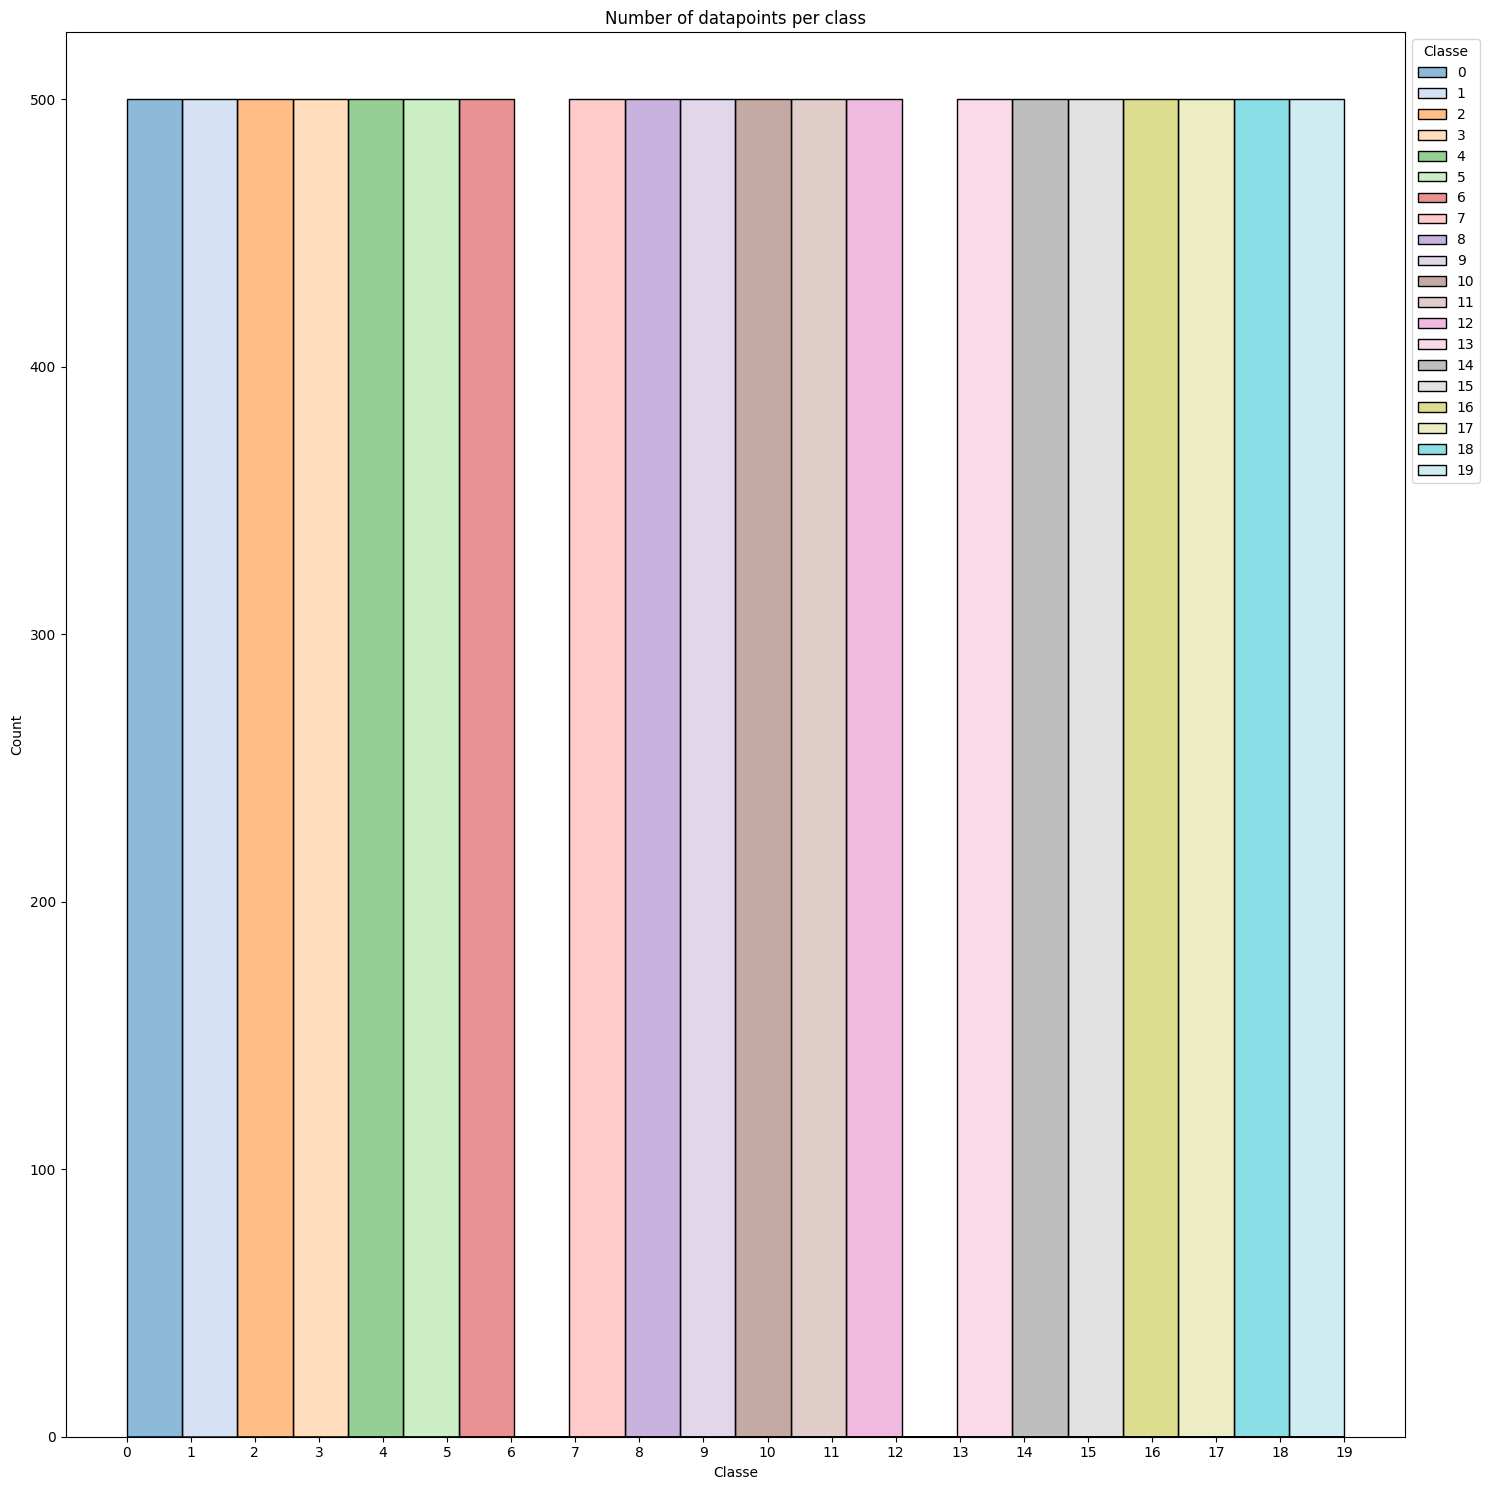

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
g = sns.histplot(df, x=class_name, hue=class_name, palette="tab20", legend="full")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
g.set_xticks(range(len(df[class_name].unique())))
g.set_xticklabels(list(range(0, 20)))
ax.set_title("Number of datapoints per class")
fig.tight_layout()

Yes classes are balanced

#### Correlations of features with classes

In [21]:
print(f"We have {len(df[class_name].unique())} classes")

We have 20 classes


In [22]:
df.corr()

Attribut1  Attribut2  Attribut3  Attribut4    Classe
Attribut1   1.000000  -0.083767   0.004046   0.178558  0.364229
Attribut2  -0.083767   1.000000   0.028610   0.262127 -0.158917
Attribut3   0.004046   0.028610   1.000000   0.048547  0.006596
Attribut4   0.178558   0.262127   0.048547   1.000000  0.065589
Classe      0.364229  -0.158917   0.006596   0.065589  1.000000

<Axes: >

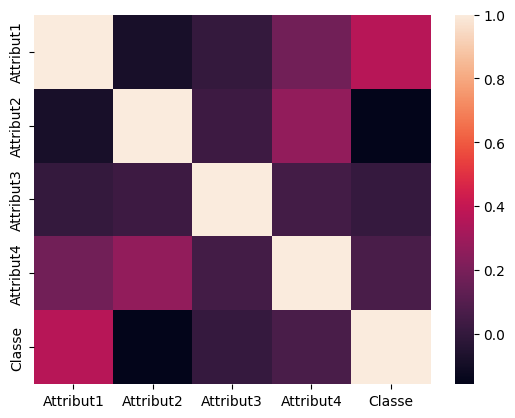

In [23]:
# Pairplot for features
sns.heatmap(df.corr())



No correlation between class and features with this model. Since we have a lot of objects (10k) and a lot of classes (20)

**Let's look at data with dimensionality reduction applied to see if our classes our well separated**

<Axes: xlabel='pc1', ylabel='pc2'>

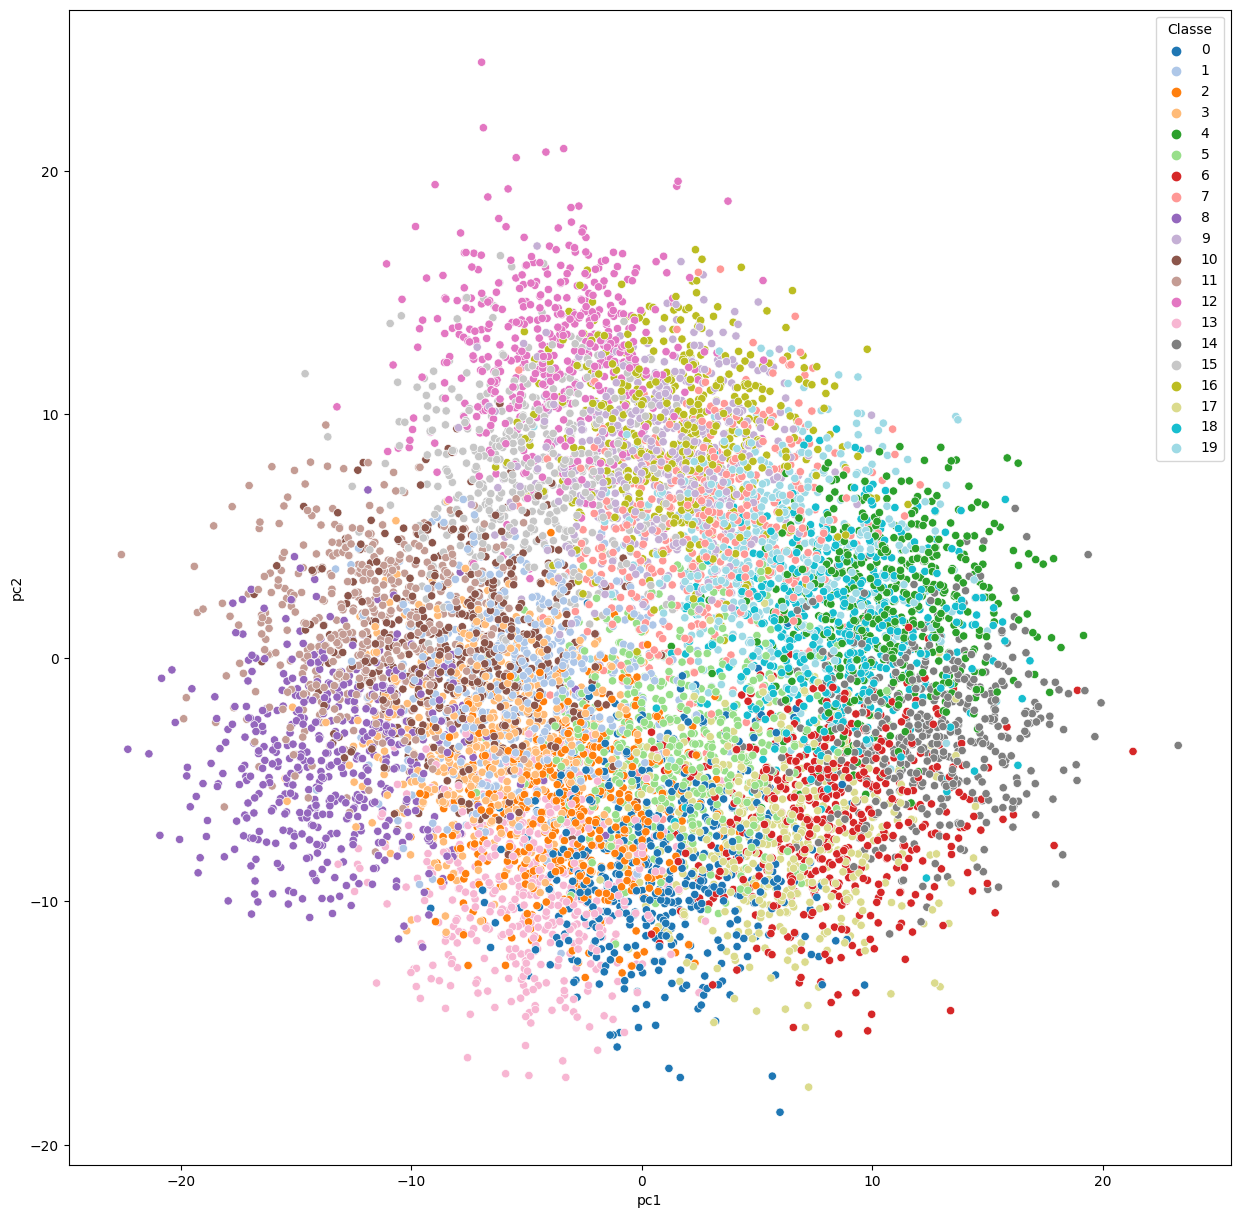

In [24]:
# Fit and save as df
pca = PCA(n_components=2).fit(X)
X_2d = pd.DataFrame(pca.transform(X), columns=["pc1", "pc2"])
# Plot the PCA
fig = plt.subplots(figsize=(15,15))
sns.scatterplot(X_2d, x="pc1", y="pc2", hue=y, legend="full", palette="tab20")


OK lot's of overlap, maybe the local similarities are strong and the differences not so large. Let's look at t-SNE representation

<Axes: xlabel='dim1', ylabel='dim2'>

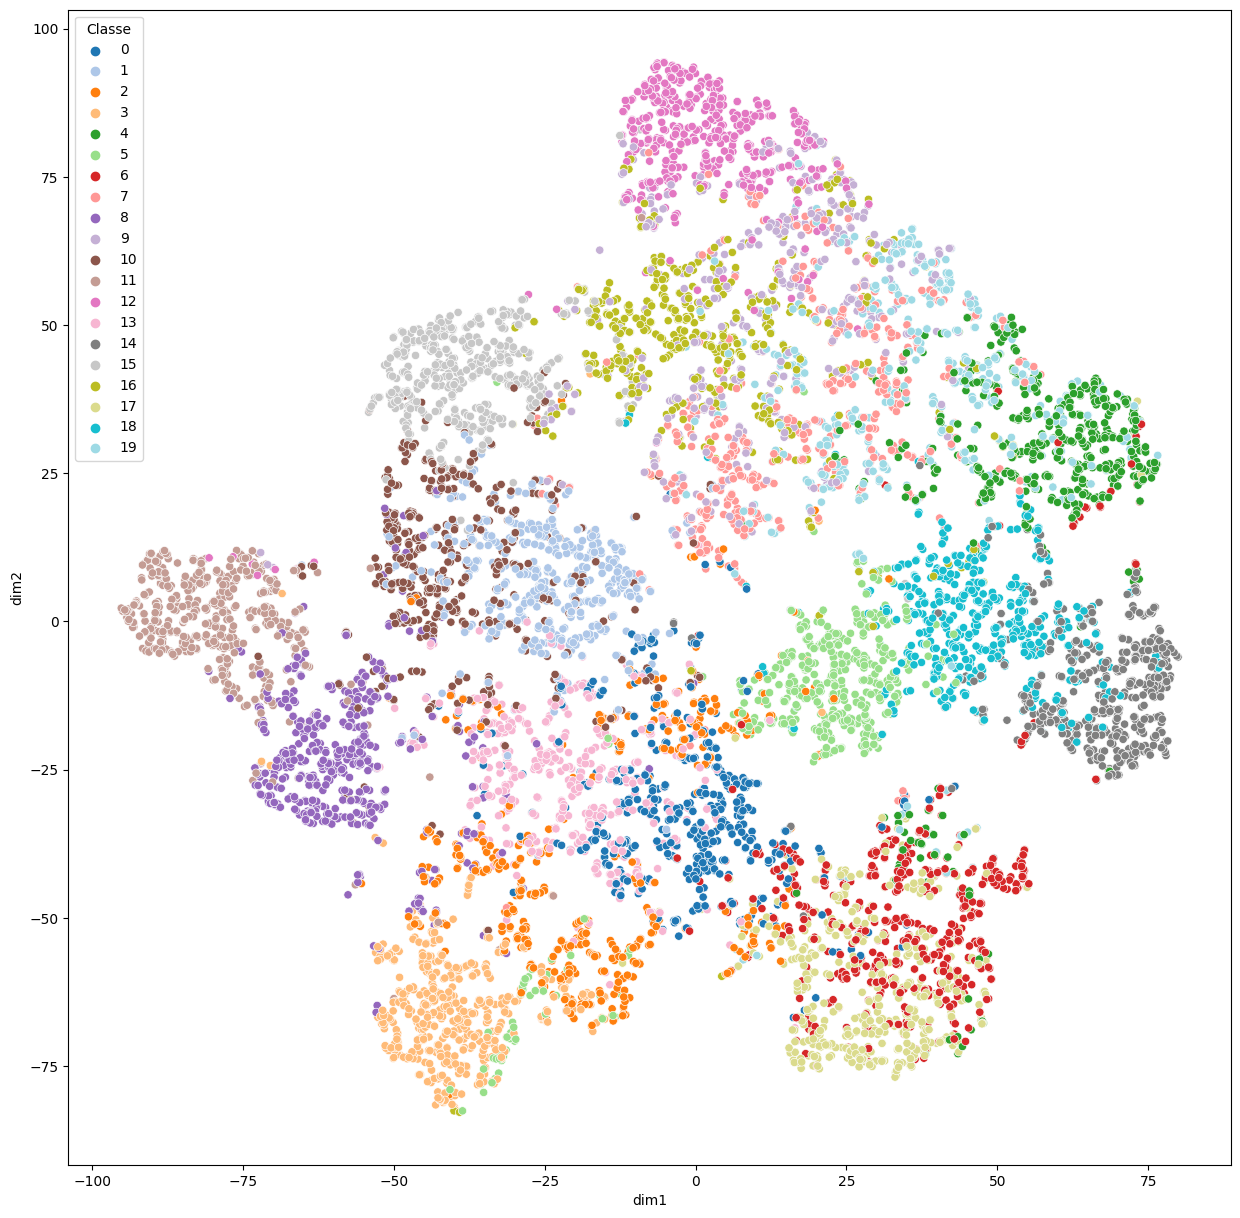

In [25]:
tsne = TSNE(n_components=2).fit_transform(X)
X_tsne = pd.DataFrame(tsne, columns=["dim1", "dim2"])
# Plot the reduced data
fig = plt.subplots(figsize=(15,15))
sns.scatterplot(X_tsne, x="dim1", y="dim2", hue=y, legend="full", palette="tab20")

**Much better representation, we see that some classes are clearly clustered and well separated from other (homogenous) and other will be more heterogenous**

## 1. Score and hyperparameter optimization functions implementation

#### a) model_score implementation that returns the score (accuracy) of a given classification model (X data, y classes) with a k=5 Cross-Fold validation

In [28]:
def model_score(X, y, classifier, params: dict, show_full_score=False, show_mean_std=True):
    """
    implementation that returns the score (accuracy) of a given classification model (X data, y classes)
    with a k=5 Cross-Fold validation

    Args:
        X (pd.DataFrame or np.array): Dataset with final attributes values to train and test the model
        y (pd.Series or np.array): Known classes for all objects
        classifier: sklearn instanciated class object from a given classifier (i.e. KNeighbordsClassifier)
        params (dict): dictionary with the a given set of hyperparameters (i.e. params = {"n_neighbors": 10, "p": 5})
        show_full_score (bool): Show all scores from each fold if True
        show_mean_std (bool): Show mean and standard deviation aggregation from each fold if True
    
    Returns:
        mean_test_score (float): Mean accuracy from 5-fold CV evaluation of the classifier for predictions accross the whole dataset
    """
    # Params key and range
    n_range = range(1, 21)
    p_range = range(1, 11)
    params_keys = ["p", "n_neighbors"]

    # Validate arguments    
    if [key for key in params.keys()][0] not in params_keys or [key for key in params.keys()][1] not in params_keys:
        raise KeyError(f"params keys must be {params_keys}")
    if params["n_neighbors"] not in n_range:
        raise ValueError(f"n_neighbors must be within {n_range}")
    if params["p"] not in p_range:
        raise ValueError(f"p must be within {p_range}")

    # Partition in stratified k=5 folds (balanced class = regular KFold) with pre-shuffle but random seed set to compare accross hyperparams runs
    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

    # Modify the objects attributes with the given parameters
    clf = classifier
    clf.set_params(n_neighbors=params["n_neighbors"], p=params["p"])

    # Get all scores from cv=5
    scoring = "accuracy"
    cv_scores = cross_val_score(classifier, X, y, cv=skf, scoring=scoring)
    # Calculate mean and std
    mean_test_score = np.mean(cv_scores)
    
    if show_full_score:
        print(f'Test scores: {cv_scores}')
    if show_mean_std:
        print(f"{mean_test_score=:.4f}, std_test_score={np.std(cv_scores):.4f} with n_neighbors={params['n_neighbors']} and p={params['p']}")
    
    return mean_test_score

model_score(X, y, KNeighborsClassifier(), {"n_neighbors": 5, "p": 5}, show_full_score=True)

Test scores: [0.6975 0.683  0.694  0.6935 0.7105]
mean_test_score=0.6957, std_test_score=0.0088 with n_neighbors=5 and p=5


0.6957

#### b) bruteforce_optimisation implementation that returns the parameters (n_neighbors and p) from bruteforce search with the overall best test score

In [29]:
def bruteforce_optim(classifier, params_grid: dict, X, y):
    """Bruteforce optimisation that fits the model with every hyperparameter combinations and returns the params dict with the max test score

    Args:
        classifier (): sklearn instanciated class object from a given classifier (i.e. KNeighbordsClassifier)
        params_grid (dict): dictionary with the a given set of range of hyperparameters (i.e. params = {"n_neighbors": range(1,11), "p": range(1,6)})
        X (pd.DataFrame or np.array): Training set with final attributes values to evaluate the hyperparameters
        y (pd.Series or np.array): Known classes for all objects in the training set
    Returns:
        best_params (dict): parameters with best accuracy score
    """

    # Fit model on each hyperparameter combinations and evaluate the score
    params = {}
    best_score = None
    best_params = {}
    for n in params_grid["n_neighbors"]:
        for p in params_grid["p"]:
            params["n_neighbors"] = n
            params["p"] = p
            score = model_score(X, y, classifier, params)
            # Keep first iteration as best
            if best_score is None:
                best_score = score
                for key in params:
                    best_params[key] = params[key]
            # Keep the best scores and parameters
            if score > best_score:
                best_score = score
                for key in params:
                    best_params[key] = params[key]
    print(f"Bruteforce results: best accuracy score={best_score:.4f} achieved with n_neighbors={best_params['n_neighbors']} and p={best_params['p']}")
    return best_params

            
bruteforce_optim(KNeighborsClassifier(), params_grid={"n_neighbors" : range(3, 5), "p" : range(5, 10)}, X=X, y=y)    

mean_test_score=0.6710, std_test_score=0.0098 with n_neighbors=3 and p=5
mean_test_score=0.6713, std_test_score=0.0113 with n_neighbors=3 and p=6
mean_test_score=0.6715, std_test_score=0.0112 with n_neighbors=3 and p=7
mean_test_score=0.6713, std_test_score=0.0109 with n_neighbors=3 and p=8
mean_test_score=0.6705, std_test_score=0.0106 with n_neighbors=3 and p=9
mean_test_score=0.6861, std_test_score=0.0095 with n_neighbors=4 and p=5
mean_test_score=0.6858, std_test_score=0.0077 with n_neighbors=4 and p=6
mean_test_score=0.6848, std_test_score=0.0081 with n_neighbors=4 and p=7
mean_test_score=0.6855, std_test_score=0.0077 with n_neighbors=4 and p=8
mean_test_score=0.6866, std_test_score=0.0071 with n_neighbors=4 and p=9
Bruteforce results: best accuracy score=0.6866 achieved with n_neighbors=4 and p=9


{'n_neighbors': 4, 'p': 9}

#### c) randomize_optimisation implementation that returns the parameters (n_neighbors and p) from only a proprtion of the available search space (percent_sample)


In [37]:
def randomize_optimisation(classifier, params_grid: dict, X, y, sample_percent: int):
    """Random optimization that fits the model with a subset of random hyperparameter combinations (based on sample_percent) and returns the params dict with the max test score

    Args:
        classifier (): sklearn instanciated class object from a given classifier (i.e. KNeighbordsClassifier)
        params_grid (dict): dictionary with the a given set of range of hyperparameters (i.e. params = {"n_neighbors": range(1,11), "p": range(1,6)})
        X (pd.DataFrame or np.array): Training set with final attributes values to evaluate the hyperparameters
        y (pd.Series or np.array): Known classes for all objects in the training set
        sample_percent (int): percentage of sampled hyperparameters
    Returns:
        best_params (dict): parameters with best accuracy score
    """

    # Validate sample_percent
    if not 0 < sample_percent < 100:
        raise ValueError("sample_percent must be within 1 and 99")
    
    # Select a random hyperparameters combinations based on sample_percent
    sample_percent = sample_percent/100
    rand_n = np.random.choice(
        params_grid["n_neighbors"],
        round(len(params_grid["n_neighbors"]) * sample_percent),
        replace=False
        )
    rand_p = np.random.choice(
        params_grid["p"],
        round(len(params_grid["p"]) * sample_percent),
        replace=False)
    print(f"Calculating accuracy scores using {sample_percent*100}% of original search space from randomly selected n_neighbors={rand_n} and p={rand_p}...\n")
    
    # Fit model on each hyperparameter combinations and evaluate the score
    best_score = None
    params = {}
    best_params = {}
    
    for n in rand_n:
        for p in rand_p:
            params["n_neighbors"] = n
            params["p"] = p
            score = model_score(X, y, classifier, params)

            # Keep first iteration as best
            if best_score is None:
                best_score = score
                for key in params:
                    best_params[key] = params[key]

            # Keep the best scores and parameters
            if score > best_score:
                best_score = score
                for key in params:
                    best_params[key] = params[key]

    print(f"Randomize_optim results: best accuracy score={best_score:.4f} achieved with n_neighbors={best_params['n_neighbors']} and p={best_params['p']}")
    return best_params

randomize_optimisation(KNeighborsClassifier(), params_grid={"n_neighbors" : range(5, 11), "p" : range(5, 11)}, X=X, y=y, sample_percent=50)   

Calculating accuracy scores using 50.0% of original search space from randomly selected n_neighbors=[10  6  9] and p=[8 6 7]...

mean_test_score=0.7136, std_test_score=0.0051 with n_neighbors=10 and p=8
mean_test_score=0.7145, std_test_score=0.0044 with n_neighbors=10 and p=6
mean_test_score=0.7128, std_test_score=0.0045 with n_neighbors=10 and p=7
mean_test_score=0.7006, std_test_score=0.0029 with n_neighbors=6 and p=8
mean_test_score=0.7007, std_test_score=0.0041 with n_neighbors=6 and p=6
mean_test_score=0.7006, std_test_score=0.0034 with n_neighbors=6 and p=7
mean_test_score=0.7117, std_test_score=0.0053 with n_neighbors=9 and p=8
mean_test_score=0.7125, std_test_score=0.0055 with n_neighbors=9 and p=6
mean_test_score=0.7112, std_test_score=0.0055 with n_neighbors=9 and p=7
Randomize_optim results: best accuracy score=0.7145 achieved with n_neighbors=10 and p=6


{'n_neighbors': 10, 'p': 6}

#### d) halving_optimisation implementation that uses an incremental data partitionning and gradual hyperparameter selection to return a single set of hyperparameters to keep

In [31]:
def halving_optimisation(classifier, params_grid: dict, X, y, n_splitting: int, show_iterations=True):
    """Halving optimisation that gradually reduces the size of hyperparameter search space while increasing the amount of data used to generate scores.

    Args:
        classifier (): sklearn instanciated class object from a given classifier (i.e. KNeighbordsClassifier)
        params_grid (dict): dictionary with the a given set of range of hyperparameters (i.e. params = {"n_neighbors": range(1,11), "p": range(1,6)})
        X (pd.DataFrame or np.array): Training set with final attributes values to evaluate the hyperparameters
        y (pd.Series or np.array): Known classes for all objects in the training set
        n_splitting (int): number of splits to partition the data and hyperparams search space
    
    Returns:
        best_params (dict): parameters with best accuracy score
    """
    # Initialize best_params_indexes outside splitting
    # best_params_indexes = []
    
    # Get the complete search space size
    all_n_neighbors = list(params_grid["n_neighbors"])
    all_p = list(params_grid["p"])
    params_combinations = [(n, p) for n in all_n_neighbors for p in all_p]
    params_combinations = [(i, comb) for i, comb in enumerate(params_combinations)]
    total_space_size = len(params_combinations)
    
    # Loop through each splits
    for split in range(n_splitting):
        
        # Size of parameter space and data
        current_param_space_size = int(total_space_size * (n_splitting - split) / n_splitting)
        current_sample_space_size = int(len(X) * (split + 1) / n_splitting)

        # Bypass first split + select the parameters and data to calculate the score
        if split == 0:
            current_params = params_combinations[:current_param_space_size]
            
        else:
            # Get the best parameters taking into account the current search space
            best_params_indexes = [index for index in sorted_scores_index.keys()][:current_param_space_size]
            current_params = [params_combinations[i] for i in range(len(params_combinations)) if i in best_params_indexes]
            # print(best_params_indexes)
            # print(current_params)
        
        X_sample = X[:current_sample_space_size]
        y_sample = y[:current_sample_space_size]

        # Initialize variables and reset best_params_indexes
        scores_index = {}
        params = {}
        best_params_indexes = []

        scores_index = {}
        sorted_scores_index = {}

        # Loop through each combination and calculate the score
        for combination in current_params:
            params["n_neighbors"] = combination[1][0]
            params["p"] = combination[1][1]

            
            # Calculate score
            score = model_score(X_sample, y_sample, classifier, params, show_mean_std=False)
            
            # Save score with param_combination index and reverse sort
            scores_index[combination[0]] = score

        # Sort param indexes by best scoring accuracy
        sorted_scores_index = {k: v for k, v in sorted(scores_index.items(), key=lambda item: item[1], reverse=True)}

        # Retrieve top5 for current split
        top5_accuracies = [val for val in sorted_scores_index.values()][:5]
        top5_combinations_index = [index for index in sorted_scores_index.keys()][:5]
        top5_combinations = [comb for i, comb in current_params if i in top5_combinations_index]

        top5_n = [comb[0] for comb in top5_combinations]
        top5_p = [comb[1] for comb in top5_combinations]
        
        if show_iterations:
            print(f"""
                Top accuracy={top5_accuracies} for n_neighbors={top5_n} and p={top5_p}
                at search_space of size={current_param_space_size} and sample_size={current_sample_space_size}
                and split iteration #{split+1}
                """
            )

    # Save best combination of hyperparameter from last split
    best_combination = top5_combinations[0]
    top_accuracy = top5_accuracies[0]
    best_params = {"n_neighbors" : top5_n[0], "p" : top5_p[0]}
    print(f"""
        Best combination of hyperparameters (original index, (n_neigh, p)) {best_combination}
        Accuracy={top_accuracy:.4f} with n_neighbors={best_params["n_neighbors"]} and p={best_params["p"]}
        at the last split with n_splitting={split +1} and last search space of size={current_param_space_size} and whole sample size of {current_sample_space_size}
        """
    )
    
    return best_params


halving_optimisation(
    KNeighborsClassifier(),
    params_grid={"n_neighbors" : range(5, 11), "p" : range(5, 11)},
    X=X,
    y=y,
    n_splitting=5,
    show_iterations=True
)


                Top accuracy=[0.7135, 0.7135, 0.7135, 0.7130000000000001, 0.712] for n_neighbors=[10, 10, 10, 10, 10] and p=[5, 7, 8, 9, 10]
                at search_space of size=36 and sample_size=2000
                and split iteration #1
                

                Top accuracy=[0.7085000000000001, 0.70825, 0.70825, 0.70775, 0.7072499999999999] for n_neighbors=[9, 10, 10, 10, 10] and p=[5, 5, 8, 9, 10]
                at search_space of size=28 and sample_size=4000
                and split iteration #2
                

                Top accuracy=[0.7070000000000001, 0.7058333333333333, 0.7055, 0.7055, 0.7050000000000001] for n_neighbors=[9, 9, 10, 10, 10] and p=[5, 6, 7, 8, 10]
                at search_space of size=21 and sample_size=6000
                and split iteration #3
                

                Top accuracy=[0.717875, 0.71625, 0.716, 0.7152499999999999, 0.715125] for n_neighbors=[10, 10, 10, 10, 10] and p=[5, 6, 7, 8, 9]
                at search_spac

{'n_neighbors': 10, 'p': 5}

#### e) bayesian optimisation implementation that uses an approximation function that to estimate a score by sampling.

In [147]:
def bayesian_optimisation(classifier, params_grid: dict, X, y, s_size: int, n_iter: int):
    """_summary_

    Args:
        classifier (): sklearn instanciated class object from a given classifier (i.e. KNeighbordsClassifier)
        params_grid (dict): dictionary with the a given set of range of hyperparameters (i.e. params = {"n_neighbors": range(1,11), "p": range(1,6)})
        X (pd.DataFrame or np.array): Training set with final attributes values to evaluate the hyperparameters
        y (pd.Series or np.array): Known classes for all objects in the training set
        s_size (int): Size of sampled hyperparameters at each iteration (i.e. s_size = 5)
        n_iter (int): Number of iterations to perform (i.e. n_iter = 100)
    
    Returns:
        best_params (dict): 
    """
    # Get the complete search space size
    all_n_neighbors = list(params_grid["n_neighbors"])
    all_p = list(params_grid["p"])
    params_combinations = [(n, p) for n in all_n_neighbors for p in all_p]

    # Generate a list of dictionaries + dataframe with all searchspace
    all_params_list = []
    
    for comb in params_combinations:
        params = {}
        params["n_neighbors"] = comb[0]
        params["p"] = comb[1]
        all_params_list.append(params)
    
    all_params_df = pd.DataFrame(all_params_list)
    
    # Select random hyperparameters combinations (E) based on s_size
    rand_comb_E = random.sample(params_combinations, k=s_size)
    
    # Initialize list containers
    E_params_list = []
    scores = []

    # Generate model_score input and calculate scores for each combination
    print(f"Generating scores with {s_size} randomly selected combinations...")
    for comb in rand_comb_E:
        params = {}
        params["n_neighbors"] = comb[0]
        params["p"] = comb[1]
        E_params_list.append(params)
        
        score = model_score(X, y, classifier, params, show_mean_std=False)
        scores.append(score)

    # Convert params_list to df
    E_params_df = pd.DataFrame(E_params_list)
    
    # Fit the Gaussian Process Regressor to the initial sample
    print(f"Fitting the GPR before the {n_iter} iterations")
    gpr = GaussianProcessRegressor()
    gpr.fit(E_params_df, scores)
    print(f"Scores from the initial {s_size} random hyperparam combinations : {scores}\n")
    
    # Iterate and predict scores for all hyperparams with prob func
    for i in range(n_iter):
        mu, sig = gpr.predict(all_params_df, return_std=True)
        
        # Get maximum average of pred scores
        max_pred_avg = max(mu)
        
        # Sample s_size params randomly
        new_params = random.sample(all_params_list, k=s_size)
        new_params_df = pd.DataFrame(new_params)
        
        # Predict scores for subset of random hyperparams of s_size with current prob func
        mu_new, sig_new = gpr.predict(new_params_df, return_std=True)

        # Transform the predictions into a probability distribution using the cdf
        probabilities = norm.cdf((mu_new - max_pred_avg) / (sig_new + 1e-6))

        # Choose the hyperparameter setting with maximum probability
        max_param_index = np.argmax(probabilities)
        max_param = new_params[max_param_index]
        max_param_df = pd.DataFrame([max_param])
        
        # Append max_param to E, calculate score and refit model
        E_params_df = pd.concat([E_params_df, max_param_df], ignore_index=True)
        
        print(f"Calculating score for max param with approximation function from iteration {i + 1}")
        max_param_score = model_score(X, y, classifier, max_param, show_mean_std=False)
        print(f"max param score at current iteration = {max_param_score}\n")
        scores.append(max_param_score)
        
        gpr.fit(E_params_df, scores)

    # Return best parameters from E after n_iter iterations
    best_param_index = np.argmax(scores)
    best_param = E_params_df.iloc[best_param_index].to_dict()
    print(f"Best hyperparameters combination {best_param} with score of {scores[best_param_index]:.6f}")

    return best_param
    
bayesian_optimisation(
    KNeighborsClassifier(),
    {"n_neighbors" : range(1, 6), "p" : range (6, 11)},
    X, y,
    s_size=5,
    n_iter=50
)

Generating scores with 5 randomly selected combinations...
Fitting the GPR before the 50 iterations
Scores from the initial 5 random hyperparam combinations : [0.6713000000000001, 0.6858, 0.6713000000000001, 0.6302, 0.6308999999999999]

Calculating score for max param with approximation function from iteration 1
max param score at current iteration = 0.6927

Calculating score for max param with approximation function from iteration 2
max param score at current iteration = 0.6309

Calculating score for max param with approximation function from iteration 3
max param score at current iteration = 0.6866000000000001

Calculating score for max param with approximation function from iteration 4
max param score at current iteration = 0.6308

Calculating score for max param with approximation function from iteration 5
max param score at current iteration = 0.6715

Calculating score for max param with approximation function from iteration 6
max param score at current iteration = 0.6858000000000

{'n_neighbors': 5, 'p': 6}

## 2. Optimisation function comparisons

### a) Test different data partitionning strategies with each function

#### Writing helper functions for data partitionning and scaling strategies

First I'll create an helper function to split in train/test sets more efficiently

In [148]:
# Return multiple train_test_splits with different test_sizes
def multiple_tts(X, y, test_sizes: list):
    """
    Function that generates multiple training and test sets using train_test_splits with different test_sizes
    """
    
    # Initialize dicts
    X_train, X_test, y_train, y_test = {}, {}, {}, {}
    
    # Partition data based on test_size param (random seed for repeated runs)
    for test_size in test_sizes:
        X_train[test_size], X_test[test_size], y_train[test_size], y_test[test_size] = train_test_split(X, y, test_size=test_size, random_state=0)

    return X_train, X_test, y_train, y_test

Attribut1  Attribut2  Attribut3  Attribut4
1554   7.637775  -3.418114  -4.963948   1.612481
2087  -3.144264   8.618204  -5.091692   5.127572
5470  -5.491494  -4.156375   3.952644   3.005412
2363   6.550642  -1.157854  -5.250464   5.007091
7570  -0.377753   0.783914   3.676936  -6.834488
...         ...        ...        ...        ...
9225  11.464851  -7.300147   4.954286  -2.654950
4859  -6.418174   4.438924   0.244552   7.514159
3264  -3.680281  -2.170209   3.063411 -12.806189
9845  -2.842872  -0.673961   8.554157   9.504225
2732  -0.990370   4.773103   4.976243 -11.582902

[9000 rows x 4 columns]

And a helper function for the scaler

In [ ]:
def apply_scaling(X_train: dict, X_test: dict, scaler_model):
    """
    Iterate through train/test dict, fit the model for each train/test partition and return the scaled data
    """
    X_train_scaled = {}
    X_test_scaled = {}
    # Iterate through each test_size
    for test_size in X_train.keys():
        # Fit the scaler on the given test_size
        fitted_scaler = scaler_model.fit(X_train[test_size])
        # Transform train and test sets from fitted scaler
        X_train_scaled[test_size] = pd.DataFrame(fitted_scaler.transform(X_train[test_size]), columns=[f"{feat}_scaled" for feat in features])
        X_test_scaled[test_size] = pd.DataFrame(fitted_scaler.transform(X_test[test_size]), columns=[f"{feat}_scaled" for feat in features])

    return X_train_scaled, X_test_scaled

#### Splitting and scaling propositions

**Let's split with different test sizes ratio of 10, 20, 30, 40 and 50% compared to full dataset**

In [158]:
# Split with 5 ratios
X_train, X_test, y_train, y_test = multiple_tts(X, y, test_sizes=[0.1, 0.2, 0.3, 0.4, 0.5])

print(X_train.keys())
X_train[0.3]

dict_keys([0.1, 0.2, 0.3, 0.4, 0.5])


Attribut1  Attribut2  Attribut3  Attribut4
1554   7.637775  -3.418114  -4.963948   1.612481
2087  -3.144264   8.618204  -5.091692   5.127572
5470  -5.491494  -4.156375   3.952644   3.005412
2363   6.550642  -1.157854  -5.250464   5.007091
7570  -0.377753   0.783914   3.676936  -6.834488
...         ...        ...        ...        ...
9225  11.464851  -7.300147   4.954286  -2.654950
4859  -6.418174   4.438924   0.244552   7.514159
3264  -3.680281  -2.170209   3.063411 -12.806189
9845  -2.842872  -0.673961   8.554157   9.504225
2732  -0.990370   4.773103   4.976243 -11.582902

[9000 rows x 4 columns]

**Apply MinMax and StandardScaler to partitionned train set dataset without leakage to the test set since it was splitted before the scaling**

In [162]:
# Apply MinMax scaling
X_train_minmax, X_test_minmax = apply_scaling(X_train, X_test, MinMaxScaler())

print(X_train_minmax.keys())
X_train_minmax[0.3]

dict_keys([0.1, 0.2, 0.3, 0.4, 0.5])


Attribut1_scaled  Attribut2_scaled  Attribut3_scaled  Attribut4_scaled
0             0.638870          0.351521          0.718754          0.260977
1             0.611298          0.223583          0.297465          0.447914
2             0.655985          0.318937          0.805504          0.370856
3             0.390863          0.222681          0.602156          0.665646
4             0.672692          0.492565          0.392005          0.628408
...                ...               ...               ...               ...
6995          0.835965          0.318202          0.645577          0.475085
6996          0.332859          0.638493          0.514313          0.721315
6997          0.409885          0.458168          0.592877          0.229287
6998          0.433443          0.498992          0.745909          0.769502
6999          0.485560          0.647610          0.646189          0.258907

[7000 rows x 4 columns]

In [160]:
# Apply StandardScaler
X_train_std, X_test_std = apply_scaling(X_train, X_test, StandardScaler())

print(X_train_std.keys())
X_train_std[0.3]

dict_keys([0.1, 0.2, 0.3, 0.4, 0.5])


Attribut1_scaled  Attribut2_scaled  Attribut3_scaled  Attribut4_scaled
0             0.465913         -0.809475          1.290018         -1.546529
1             0.325192         -1.602901         -1.287628         -0.433692
2             0.553262         -1.011552          1.820802         -0.892417
3            -0.799860         -1.608491          0.576620          0.862471
4             0.638530          0.065220         -0.709190          0.640789
...                ...               ...               ...               ...
6995          1.471840         -1.016107          0.842290         -0.271943
6996         -1.095898          0.970205          0.039151          1.193869
6997         -0.702777         -0.148095          0.519844         -1.735180
6998         -0.582537          0.105078          1.456167          1.480724
6999         -0.316546          1.026750          0.846034         -1.558851

[7000 rows x 4 columns]

**Now we have different training/test sizes and also 2 scaling strategies for each set combinations**

5 train/test combinations * 2 scaling strategies = 10 partitionning

### b) Heatmap for accuracy scores for all possible search space (bruteforce) using each partitioning

Let's copy an identical function to bruteforce_optim but that returns a dataframe with the scores of each n_neighbors and p combinations

In [270]:
def whole_space_search(classifier, params_grid, X_train, y_train, X_test, y_test, verbose=True):
    """_summary_

    Args:
        classifier (_type_): _description_
        params_grid (_type_): _description_
        X (_type_): _description_
        y (_type_): _description_
    """
    # Initialize scores/params list
    training_cv_scores = []
    test_scores = []
    
    # Fit model on each hyperparameter combinations and evaluate the score

    for n in params_grid["n_neighbors"]:
        for p in params_grid["p"]:
            
            # Initialize/reset params+scores for training dict
            training_params_scores = {}
            
            # Get current iteration params for training dict
            training_params_scores["n_neighbors"] = n
            training_params_scores["p"] = p
            if verbose:
                print(f"For n_neighbors={n} and {p=}")
            
            # Calulcate training score and save to list
            train_score = model_score(X_train, y_train, classifier, training_params_scores, show_mean_std=False)
            if verbose:
                print(f"{train_score=:.4f}")
            
            training_params_scores["train_score"] = train_score
            training_cv_scores.append(training_params_scores)

            # Initialize/reset params+scores for test_dict
            test_params_scores = {}

            # Get current iteration params for test dict
            test_params_scores["n_neighbors"] = n
            test_params_scores["p"] = p
            
            # Fit the model on training set with current params
            clf = classifier.set_params(n_neighbors=test_params_scores["n_neighbors"], p=test_params_scores["p"])
            clf.fit(X_train, y_train)
            
            # Get predictions and accuracy score model fitted on train set + save to list
            y_pred = clf.predict(X_test)
            test_score = accuracy_score(y_test, y_pred)
            if verbose:
                print(f"{test_score=:.4f}\n")
                        
            test_params_scores["test_score"] = test_score
            test_scores.append(test_params_scores)

    # Save to dataframe and print top5 combinations
    train_scores_df = pd.DataFrame(training_cv_scores)    # Training params/scores
    if verbose:
        print("\n Top 5 hyperparameter combinations for training set :")
        display(train_scores_df.sort_values(by="train_score", ascending=False)[:5])

    test_scores_df = pd.DataFrame(test_scores)    # Test params/scores
    if verbose:
        print("\n Top 5 hyperparameter combinations for test set :")
        display(test_scores_df.sort_values(by="test_score", ascending=False)[:5])
    
    return train_scores_df, test_scores_df

Testing the function

In [250]:
testingfunc_train, testingfunc_test = whole_space_search(
    classifier=KNeighborsClassifier(),
    params_grid={"n_neighbors" : range(1, 21), "p" : range(1, 11)},
    X_train=X_train[0.2],
    y_train=y_train[0.2],
    X_test=X_test[0.2],
    y_test=y_test[0.2]
)

For n_neighbors=1 and p=1
train_score=0.6366
test_score=0.6300

For n_neighbors=1 and p=2
train_score=0.6360
test_score=0.6285

For n_neighbors=1 and p=3
train_score=0.6350
test_score=0.6290

For n_neighbors=1 and p=4
train_score=0.6358
test_score=0.6295

For n_neighbors=1 and p=5
train_score=0.6352
test_score=0.6340

For n_neighbors=1 and p=6
train_score=0.6346
test_score=0.6355

For n_neighbors=1 and p=7
train_score=0.6335
test_score=0.6355

For n_neighbors=1 and p=8
train_score=0.6320
test_score=0.6365

For n_neighbors=1 and p=9
train_score=0.6313
test_score=0.6340

For n_neighbors=1 and p=10
train_score=0.6316
test_score=0.6330

For n_neighbors=2 and p=1
train_score=0.6278
test_score=0.6325

For n_neighbors=2 and p=2
train_score=0.6334
test_score=0.6245

For n_neighbors=2 and p=3
train_score=0.6320
test_score=0.6265

For n_neighbors=2 and p=4
train_score=0.6299
test_score=0.6310

For n_neighbors=2 and p=5
train_score=0.6300
test_score=0.6290

For n_neighbors=2 and p=6
train_score=0

n_neighbors  p  train_score
170           18  1     0.729375
190           20  1     0.729250
198           20  9     0.728750
180           19  1     0.728250
181           19  2     0.728250


 Top 5 hyperparameter combinations for test set :


n_neighbors  p  test_score
192           20  3      0.7230
141           15  2      0.7220
171           18  2      0.7205
161           17  2      0.7205
191           20  2      0.7200

Text(0.5, 1.0, 'Test size of 0.3, no scaling')

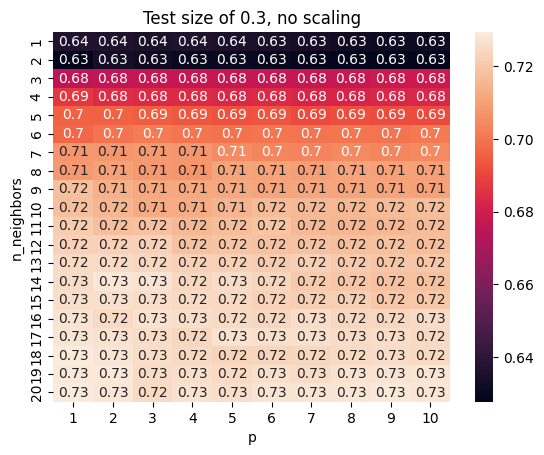

In [251]:
# Create a pivot table
testingfunc_train_pivot = testingfunc_train.pivot(index="n_neighbors", columns="p", values="train_score")

# Plotting as a heatmap
fig, ax = plt.subplots()
sns.heatmap(testingfunc_train_pivot, annot=True, ax=ax)
ax.set_title("Test size of 20%, no scaling")

In [264]:
def plot_scores_heatmap(train_scores_df, test_scores_df, test_size, scaling):
    """
    Plots heatmaps of training and test scores for different hyperparameter combinations.

    This function takes in dataframes of training and test scores for different hyperparameter combinations and plots heatmaps of the scores. The heatmaps show how the scores change with different hyperparameter values.

    Args:
        train_scores_df (pd.DataFrame): A dataframe containing the training scores for different hyperparameter combinations.
        test_scores_df (pd.DataFrame): A dataframe containing the test scores for different hyperparameter combinations.
        test_size (float): The proportion of the dataset to include in the test split.
        scaling (str): The scaling method used to preprocess the data.

    Returns:
        None
    """
    
    # Create pivot tables for train and test dfs
    train_scores_df_pivot = train_scores_df.pivot(
        index=train_scores_df.columns[0],
        columns=train_scores_df.columns[1],
        values=train_scores_df.columns[2]
    )
    test_scores_df_pivot = test_scores_df.pivot(
        index=test_scores_df.columns[0],
        columns=test_scores_df.columns[1],
        values=test_scores_df.columns[2]
    )

    # Plotting the pivot tables as heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    axes = axes.ravel()

    # Training scores on left
    sns.heatmap(train_scores_df_pivot, annot=True, ax=axes[0])    
    axes[0].set_title("Training scores")
    
    # Test scores on right
    sns.heatmap(test_scores_df_pivot, annot=True, ax=axes[1])    
    axes[1].set_title("Test scores")

    fig.suptitle(f"Whole search space with {test_size=} and {scaling=}", weight="bold")
    fig.tight_layout()

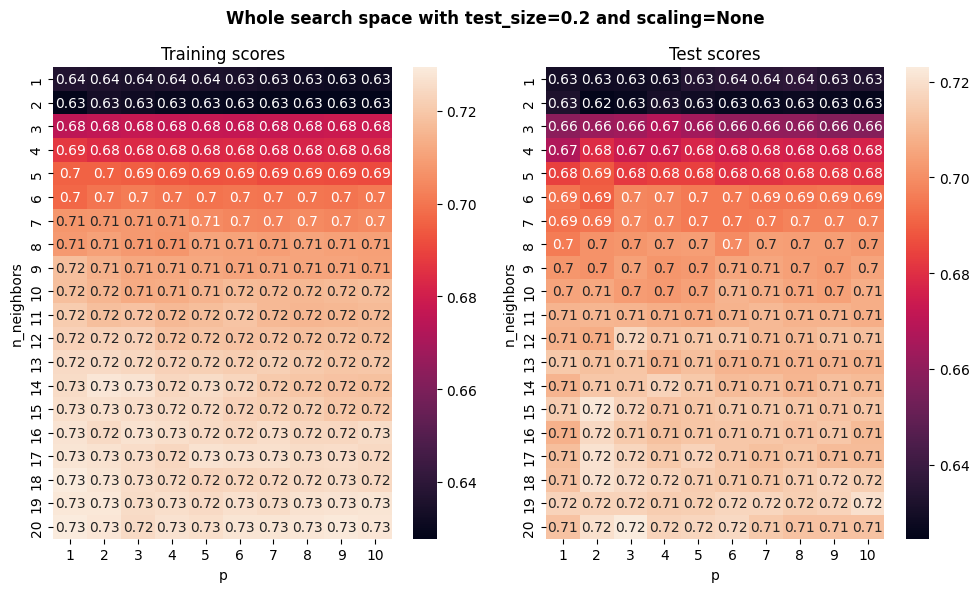

In [265]:
plot_scores_heatmap(testingfunc_train, testingfunc_test, 0.2, None)

#### Visualizing Training and Test scores on the whole search space
I will use non-scaled (untransformed) data, minmax and standardized data with test_size of 0.1, 0.3, 0.5

In [275]:
test_size_range = [0.1, 0.3, 0.5]

**Untransformed data**

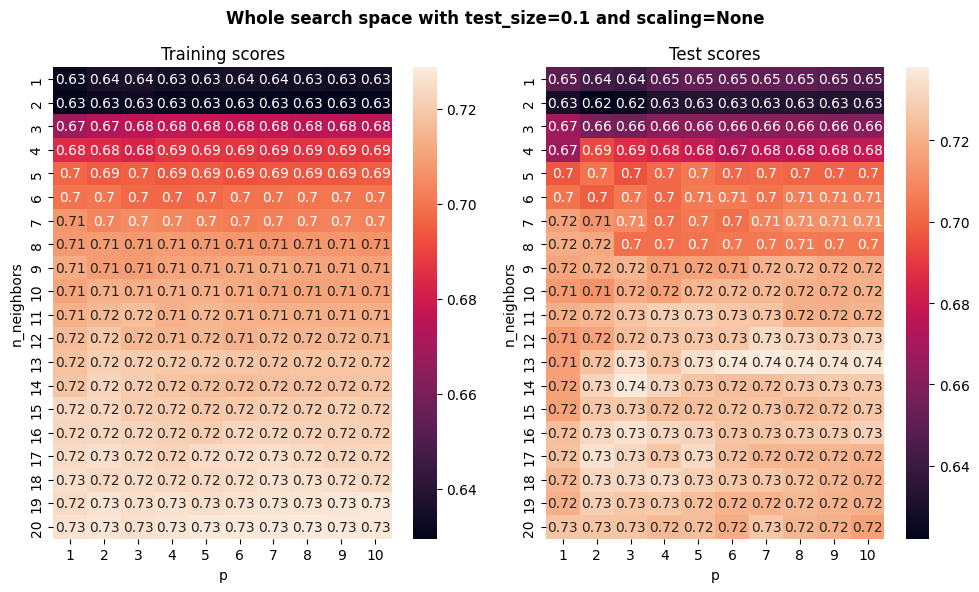

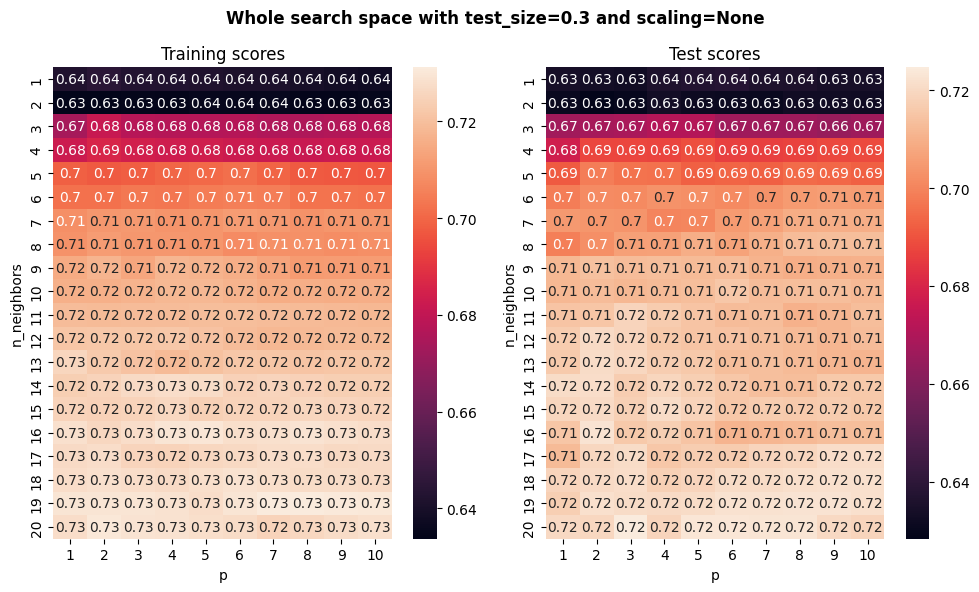

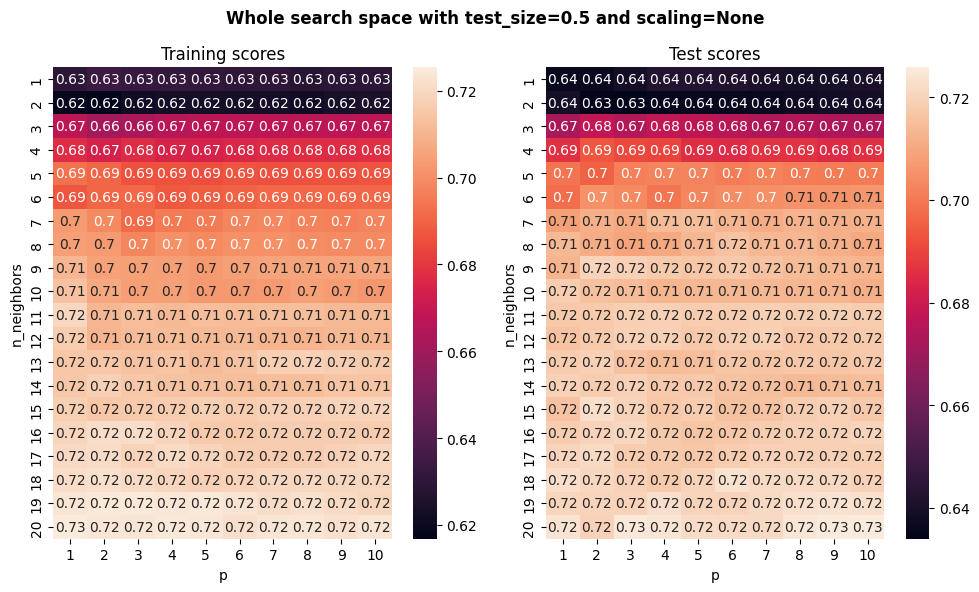

In [276]:
for i in test_size_range:
    train_scores_df, test_scores_df = whole_space_search(
        classifier=KNeighborsClassifier(),
        params_grid={"n_neighbors" : range(1, 21), "p" : range(1, 11)},
        X_train=X_train[i],
        y_train=y_train[i],
        X_test=X_test[i],
        y_test=y_test[i],
        verbose=False
    )
    plot_scores_heatmap(train_scores_df, test_scores_df, i, None)

**MinMax transformed data**

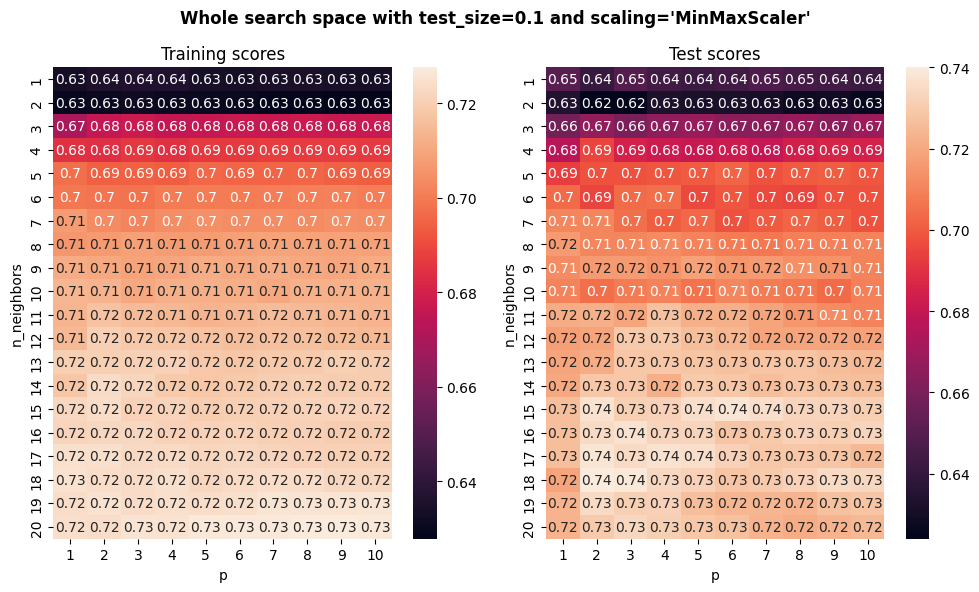

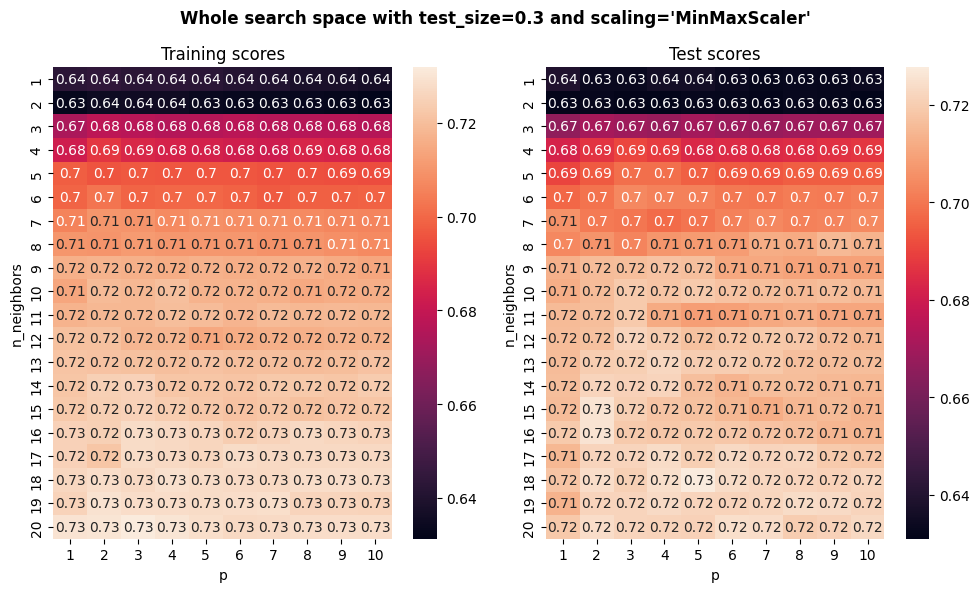

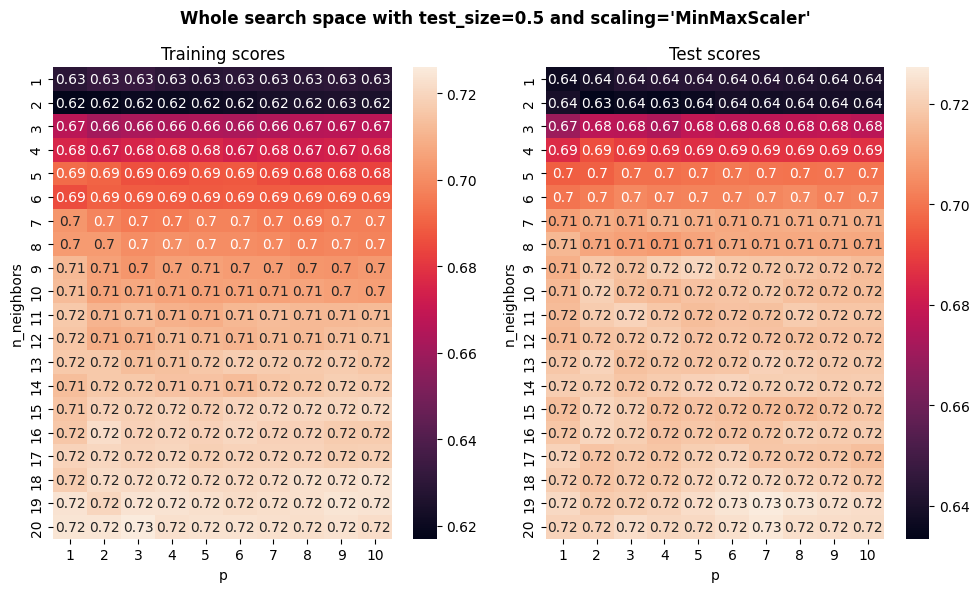

In [279]:
for i in test_size_range:
    train_scores_df, test_scores_df = whole_space_search(
        classifier=KNeighborsClassifier(),
        params_grid={"n_neighbors" : range(1, 21), "p" : range(1, 11)},
        X_train=X_train_minmax[i],
        y_train=y_train[i],
        X_test=X_test_minmax[i],
        y_test=y_test[i],
        verbose=False
    )
    plot_scores_heatmap(train_scores_df, test_scores_df, i, "MinMaxScaler")

**StandardScaler transformed data**

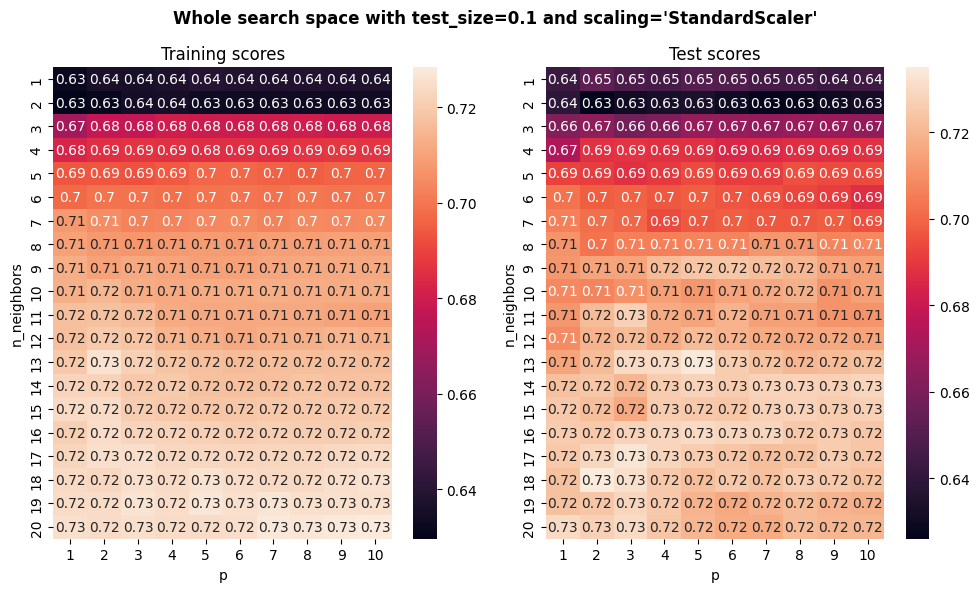

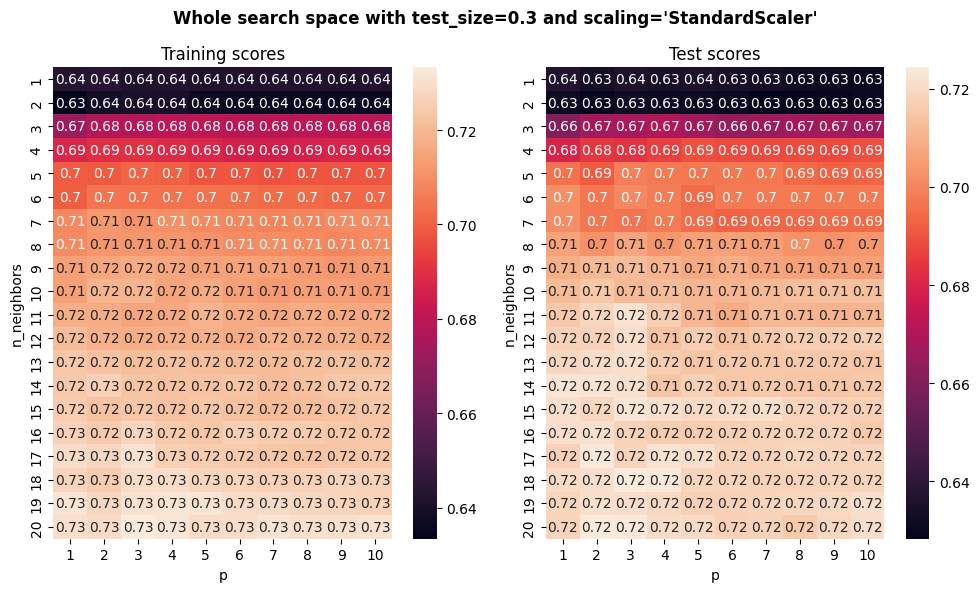

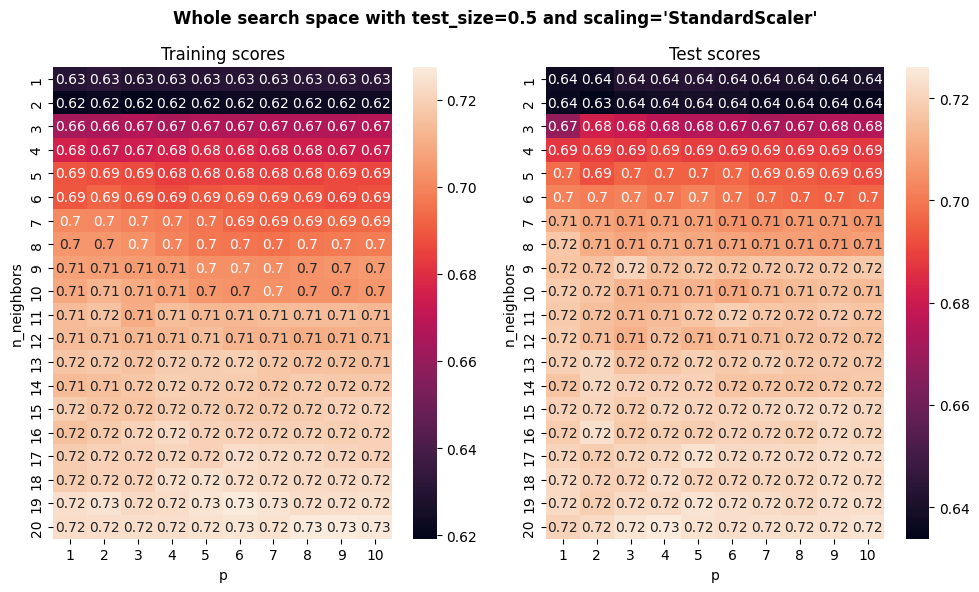

In [280]:
for i in test_size_range:
    train_scores_df, test_scores_df = whole_space_search(
        classifier=KNeighborsClassifier(),
        params_grid={"n_neighbors" : range(1, 21), "p" : range(1, 11)},
        X_train=X_train_std[i],
        y_train=y_train[i],
        X_test=X_test_std[i],
        y_test=y_test[i],
        verbose=False
    )
    plot_scores_heatmap(train_scores_df, test_scores_df, i, "StandardScaler")

**Overall conclusions:**
- Since Training and Test scores are not far appart, our model has a good generalization (no overfitting)
- Low test_size (0.1) have the greatest differences of score accuries between train and test scores
- The hyperparameter tuning search space remains quite large because we have a lot of combinations with really close scores, especially at higher test_sizes
- n_neighbors as a greater influence on overall scores that p
- If using bruteforce, we can lower the hyperparameter window space by using the test_scores with a small test_size
- Scores are relatively similar regardless of scaling or not

### c) Hyperparameter tuning with different optimization techniques
See previous cells for bruteforce_optimisation. I will use only

randomize_optmisation with 30% random hyperparam for whole space